In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import sys
sys.path.append('/content/References/Detection')

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


In [ ]:
from References.Detection.engine import train_one_epoch, evaluate
from References.Detection import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model_ped = get_model_instance_segmentation(num_classes)

# move model to the right device
model_ped.to(device)

# construct an optimizer
params = [p for p in model_ped.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_ped, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_ped, data_loader_test, device=device)

print("That's it!")
# Save the entire model (architecture + trained weights) to Google Drive
torch.save(model_ped, '/content/drive/MyDrive/model_ped.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [ 0/60]  eta: 0:00:56  lr: 0.000090  loss: 6.1094 (6.1094)  loss_classifier: 0.8513 (0.8513)  loss_box_reg: 0.2220 (0.2220)  loss_mask: 5.0187 (5.0187)  loss_objectness: 0.0147 (0.0147)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.9382  data: 0.2584  max mem: 5446
Epoch: [0]  [10/60]  eta: 0:00:31  lr: 0.000936  loss: 1.9545 (3.3585)  loss_classifier: 0.5683 (0.5263)  loss_box_reg: 0.2809 (0.2997)  loss_mask: 0.9129 (2.4991)  loss_objectness: 0.0184 (0.0257)  loss_rpn_box_reg: 0.0085 (0.0077)  time: 0.6206  data: 0.0319  max mem: 5947
Epoch: [0]  [20/60]  eta: 0:00:24  lr: 0.001783  loss: 1.1201 (2.1604)  loss_classifier: 0.1998 (0.3611)  loss_box_reg: 0.2538 (0.2639)  loss_mask: 0.5214 (1.4958)  loss_objectness: 0.0200 (0.0296)  loss_rpn_box_reg: 0.0097 (0.0100)  time: 0.5936  data: 0.0101  max mem: 6130
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.5729 (1.6198)  loss_classifier: 0.0964 (0.2693)  loss_box_reg: 0.1808 (0.2260)  loss_mask: 0.2582 (1.0906)  loss_ob

In [ ]:
torch.save(model_ped, '/content/drive/MyDrive/model_ped.pth')

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/model_ped.pth')

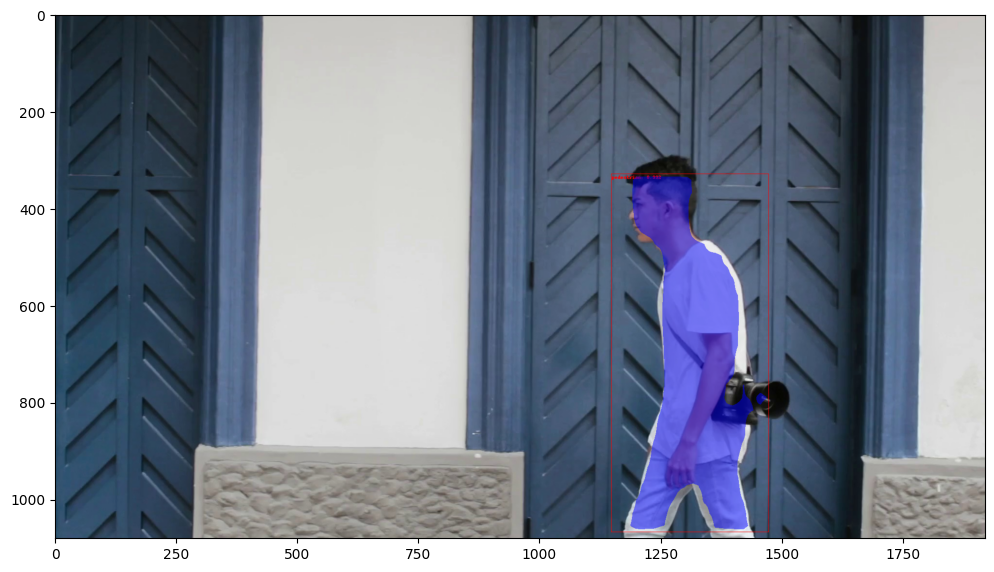

2


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Replace 'your_folder_path' with the path to your image folder
folder_path = '/content/walking_frames'

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Initialize an empty list to store predictions
all_predictions = []

# Load and predict for each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = read_image(image_path)
    eval_transform = get_transform(train=False)

    loaded_model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        # Convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = loaded_model([x, ])
        pred = predictions[0]

    # Append the predictions to the list
    all_predictions.append(pred)

# Visualize the results for the first image (you can customize this part)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(all_predictions[0]["labels"], all_predictions[0]["scores"])]
pred_boxes = all_predictions[0]["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (all_predictions[0]["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()
print(len(all_predictions))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# ... (previous code)

# Assuming all_predictions is a list containing predictions for each image
for i, pred in enumerate(all_predictions):
    # Convert segmentation masks to a list of numpy arrays
    masks = (pred["masks"] > 0.7).cpu().numpy().squeeze(1)

    # Iterate over masks and save each grayscale mask image
    for j, mask in enumerate(masks):
        # Convert to a grayscale image (0-255)
        grayscale_mask_image = (mask * 255).astype(np.uint8)

        # Save the grayscale segmentation mask image
        image_path = f'/content/Segmentation_mask_images/grayscale_mask_{i}_{j}.jpg'
        Image.fromarray(grayscale_mask_image).save(image_path)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os


# List to store keypoints and descriptors
all_keypoints = []
all_descriptors = []

import os

import os

mask_folder = '/content/Segmentation_mask_images/'
image_folder = '/content/walking_frames/'

# Get all files with .png extension in the mask folder
mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.jpg')])

# Get all files with .png extension in the image folder
image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')])

print(mask_paths)
print(image_paths)



['/content/Segmentation_mask_images/grayscale_mask_0_0.jpg', '/content/Segmentation_mask_images/grayscale_mask_1_0.jpg']
['/content/walking_frames/frame_0000.jpg', '/content/walking_frames/frame_0001.jpg']


500


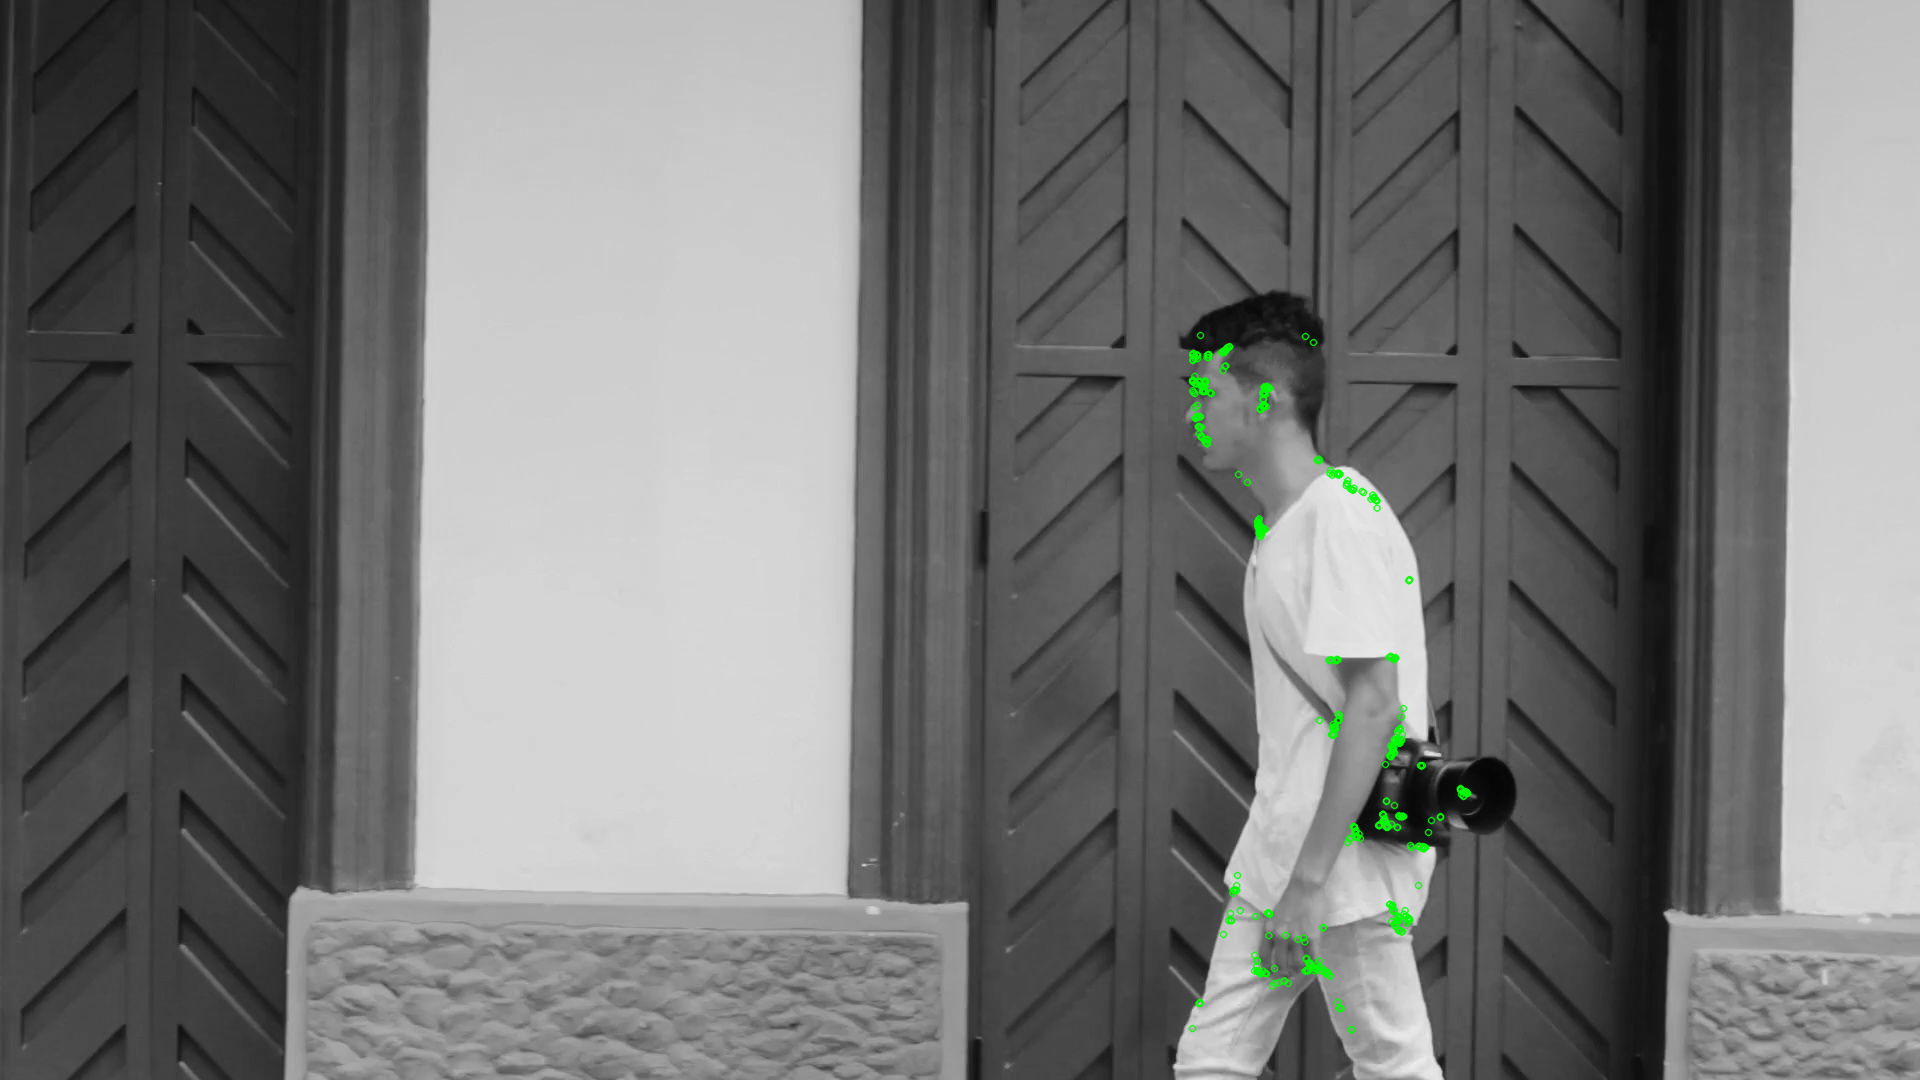

492


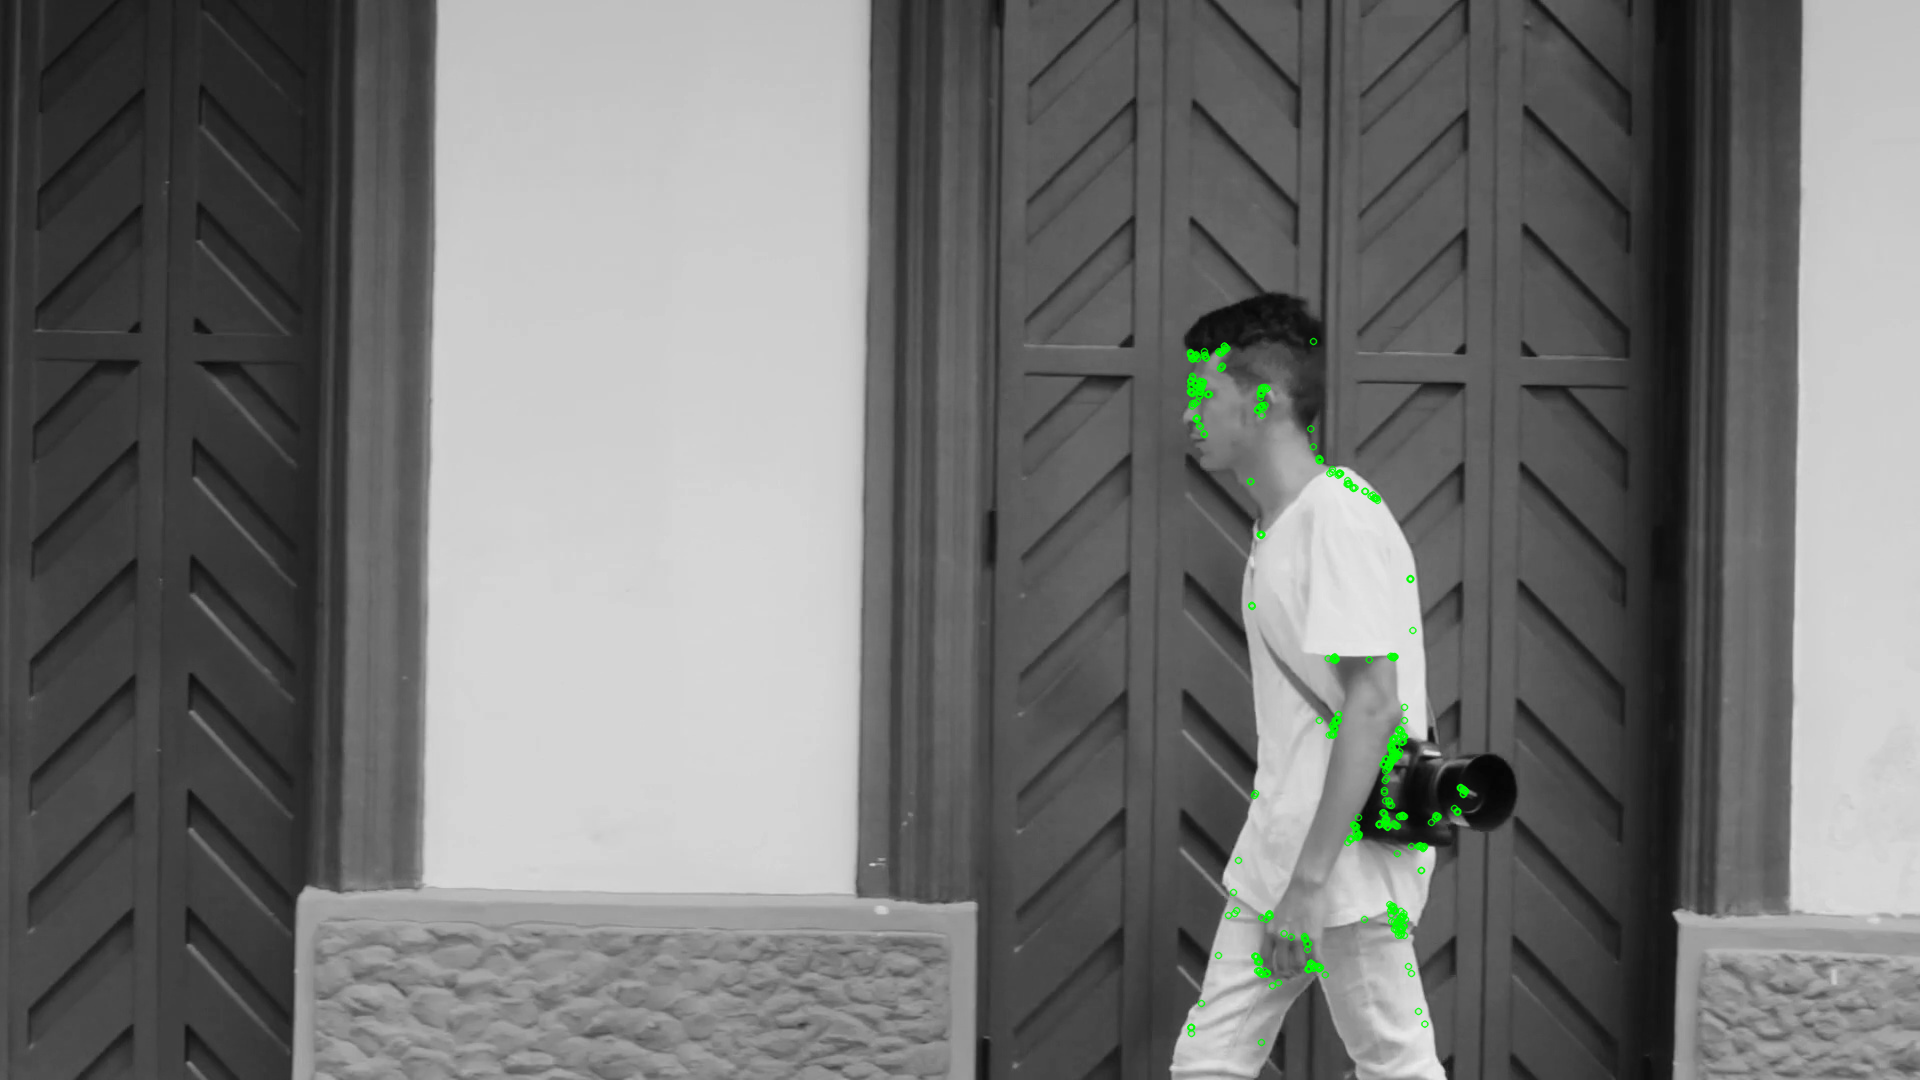

In [ ]:
from google.colab.patches import cv2_imshow
iterator = 0
for mask_path in (mask_paths):
    # Read and threshold the segmentation mask
        image_path = image_paths[iterator]

        segmentation_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, segmentation_mask = cv2.threshold(segmentation_mask, 127, 255, cv2.THRESH_BINARY)

        # Load the corresponding original image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


        # Apply the segmentation mask to the image
        roi = cv2.bitwise_and(image, image, mask=segmentation_mask)

        # Initialize ORB detector
        orb = cv2.ORB_create()

        # Find the keypoints and descriptors with ORB
        keypoints, descriptors = orb.detectAndCompute(roi, None)
        print(len(keypoints))
        # Store keypoints and descriptors in separate lists
        all_keypoints.append(keypoints)
        all_descriptors.append(descriptors)

        image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))

        # Display the images with keypoints
        cv2_imshow(image_with_keypoints)
        cv2.waitKey(0)  # Wait until a key is pressed to show the next image
        cv2.destroyAllWindows()


        iterator = iterator + 1
    # Display the keypoints on the original image

In [ ]:
import cv2
import numpy as np

# Sample keypoints and descriptors (from previous frames)
keypoints, descriptors = ..., ...  # Assuming these are your lists of keypoints and descriptors

# Split keypoints and descriptors into reference and current
keypoints_ref, descriptors_ref = keypoints[:-1], descriptors[:-1]  # All except the last
keypoints_current, descriptors_current = [keypoints[-1]], [descriptors[-1]]  # Only the last

# Match keypoints between frames
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(descriptors_ref[0], descriptors_current[0])

# Extract matched keypoints
matched_keypoints_ref = np.array([keypoints_ref[0][match.queryIdx].pt for match in matches])
matched_keypoints_current = np.array([keypoints_current[0][match.trainIdx].pt for match in matches])

# Estimate camera pose using PnP (Perspective-n-Point)
_, rvec, tvec, _ = cv2.solvePnPRansac(matched_keypoints_ref, matched_keypoints_current, camera_matrix, dist_coeffs)

# Update camera pose
# Assuming initial camera pose is identity
R, _ = cv2.Rodrigues(rvec)
current_pose = np.hstack((R, tvec))

# Optionally, perform iterative refinement using bundle adjustment

# Print the estimated camera pose
print("Estimated Camera Pose:")
print(current_pose)
